# Vehicle Detection and Tracking

The Project
---


In [194]:
import os
import numpy as np
import glob
import cv2
import time
import scipy.misc
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

## 1. Feature extraction

### 1.1 Color transformation

In [2]:
def convert_color(img, color_space='BGR'):
        # Convert image to new color space (if specified)
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'RGB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: 
        feature_image = np.copy(img)             

    # Return the feature vector
    return feature_image

### 1.2 Spatial binning

In [3]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))                  

### 1.3 Color histogram

In [4]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### 1.4 HOG features

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### 1.5 Extract feature from one image

In [6]:
# Define a function to extract features from a limage
def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, spatial_size):
    file_features = []
    
    #Spatial feature extraction
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    
    #Color feature extraction
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    
    #HOG feature extraction
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features

### 1.6 Feature extraction for all images

In [7]:
def extract_features(imgs, cspace='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file_p in imgs:
        
        file_features = []
        
        # Read in each imageone by one
        image = cv2.imread(file_p)
        
        # apply color conversion if other than 'BGR'
        feature_image = convert_color(image, color_space=cspace)
        
        #Get the features
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, spatial_size)
        
        #Append features to the list 
        features.append(np.concatenate(file_features))
        
        #Get the features and append features of flip image for augmentation
        feature_image=cv2.flip(feature_image,1) 
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, spatial_size)
        
        features.append(np.concatenate(file_features))
        
    return features # Return list of feature vectors

## 2.0 Classifier 

### 2.1 Data load

In [8]:
images = glob.iglob('Features/**/*.png', recursive=True)

cars = []
notcars = []

for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)

print("Number of vehicle images: ", len(notcars))
print("Number of non-vehicle images: ", len(cars))

Number of vehicle images:  8968
Number of non-vehicle images:  8792


### 2.2 Features extraction

In [9]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size=(32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

# Check the extraction time
t=time.time()

#Extract the car features
car_features = extract_features(cars, cspace=colorspace, 
                        spatial_size = spatial_size, hist_bins = hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

#Extract the non-cars features
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)    

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extraction...')

/home/edgarcgarzon/anaconda3/envs/VehicleDetection/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


434.92 Seconds to extraction...


### 2.3 Feature normalization

In [10]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

### 2.4 Create train and validation data

In [11]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.2, 
                                                    random_state=rand_state)

print("Train data shape: ", X_train.shape)
print("Validation data shape: ", X_test.shape)

Train data shape:  (28416, 8460)
Validation data shape:  (7104, 8460)


### 2.5 Train the clasifier

In [12]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()

svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

149.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9942


## 3. Window search

### 3.1 Load test images

In [13]:
images = glob.glob('test_images/straight_lines*.jpg')
images = images +  glob.glob('test_images/test*.jpg')

imgs = []

for idx, fname in enumerate(images):
    
    img = cv2.imread(fname)
    imgs.append(img)

### 3.2 Find cars in image

In [126]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, 
              X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins, color_space, hog_channel,
              spatial_feat=True, hist_feat=True, hog_feat=True):
    
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
       
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
 
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
       
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    #Create a list of sub-imgs and boundary boxes
    subimgs = []
    bboxs = []
    feat = []
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                
                bboxs.append(bbox)
                #for debug
                subimgs.append(subimg)
                feat.append(test_features)
                
    return bboxs, subimgs, feat

/home/edgarcgarzon/anaconda3/envs/VehicleDetection/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


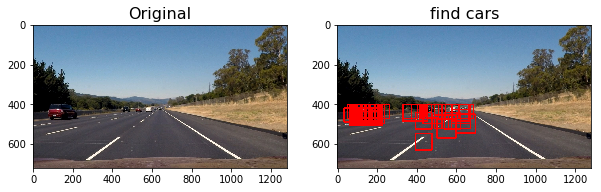

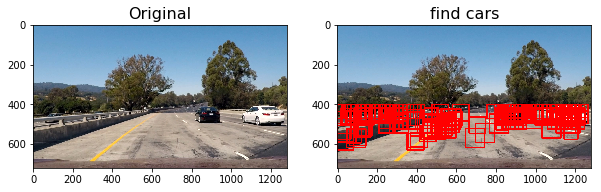

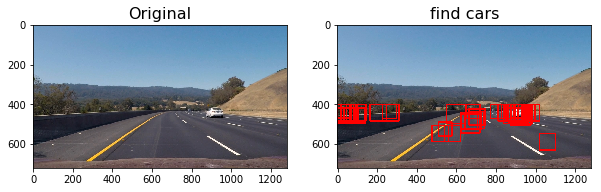

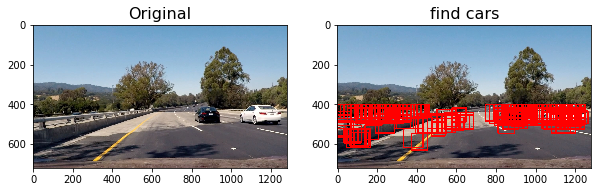

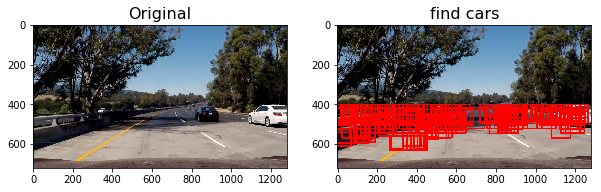

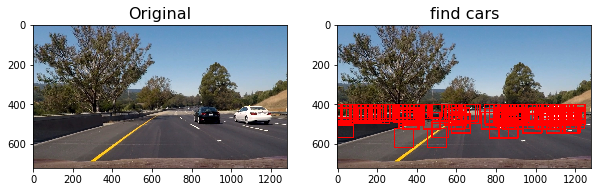

In [203]:
ystart = 400
ystop = 656
save_subim = True

list_bboxs = []

for idx1, img in enumerate(imgs): 
    
    draw_img = np.copy(img)
    
    scale = 1.0
    bboxs1, subimgs1, feat1 = find_cars(img, ystart, ystop, 
                    scale, svc, X_scaler, 
                    orient, pix_per_cell, 
                    cell_per_block, 
                    spatial_size, hist_bins, colorspace, hog_channel)
    
    scale = 1.1
    bboxs2, subimgs2, feat2 = find_cars(img, ystart, ystop, 
                    scale, svc, X_scaler, 
                    orient, pix_per_cell, 
                    cell_per_block, 
                    spatial_size, hist_bins, colorspace, hog_channel)
    
    scale = 1.3
    bboxs3, subimgs3, feat3 = find_cars(img, ystart, ystop, 
                    scale, svc, X_scaler, 
                    orient, pix_per_cell, 
                    cell_per_block, 
                    spatial_size, hist_bins, colorspace, hog_channel)
    
    scale = 1.5
    bboxs4, subimgs4, feat4 = find_cars(img, ystart, ystop, 
                    scale, svc, X_scaler, 
                    orient, pix_per_cell, 
                    cell_per_block, 
                    spatial_size, hist_bins, colorspace, hog_channel)
        
    #bboxs = bboxs1
    bboxs = bboxs1 + bboxs2 + bboxs3 + bboxs4
    list_bboxs.append(bboxs)
    subimgs = subimgs1 + subimgs2 + subimgs3 + subimgs4
    feats = feat1 + feat2 + feat3 + feat4
    
    for idx2, (bbox, subimg) in enumerate(zip(bboxs, subimgs)):
        out_img = cv2.rectangle(draw_img,bbox[0],bbox[1],(0,0,255),6)
        subimg = cv2.cvtColor(subimg, cv2.COLOR_YCrCb2BGR)*255
        cv2.imwrite("./output_images/image" + str(idx1) +" "+ str(idx2) + ".png", subimg)

        
    #display origianl and transformation images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax1.imshow(img)
    ax1.set_title('Original', fontsize=16)
    out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
    ax2.imshow(out_img)
    ax2.set_title('find cars', fontsize=16)




### (DEBUG) False positive

In [128]:
#there are 253 boxes in the last images identified as vehicles
print(len(feats))
print(len(bboxs))
print(len(subimgs))

253
253
253


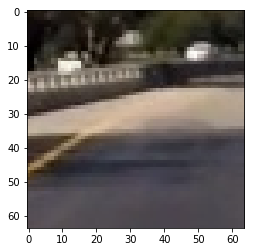

In [212]:
#Take a false positive
num = 199
im = cv2.cvtColor(subimgs[num], cv2.COLOR_YCrCb2RGB)
plt.imshow(im)

In [219]:
#Extract the features using the functions used to extract the features to trained the network

file_features = img_features(subimgs[num], spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, spatial_size)

X = np.hstack(file_features).reshape(1,-1)

print(X.shape)

(1, 8460)


/home/edgarcgarzon/anaconda3/envs/VehicleDetection/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [214]:
#compare both features and plot the difference
test_features = X_scaler.transform(X)


print(test_features.shape)
print(feats[num].shape)

print(test_features)
print(feats[num])


(1, 8460)
(1, 8460)
[[-1.56418802 -1.56921558 -1.5758712  ..., -1.04975843 -0.54986015
   0.77099642]]
[[-1.56418802 -1.56921558 -1.5758712  ..., -1.04975843 -0.25208614
   0.2884895 ]]


In [215]:
test_prediction = svc.predict(test_features)
print(test_prediction)

[ 1.]


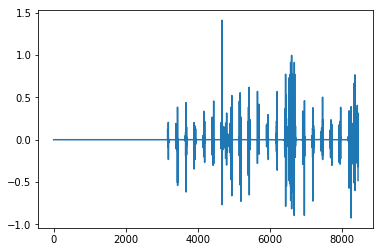

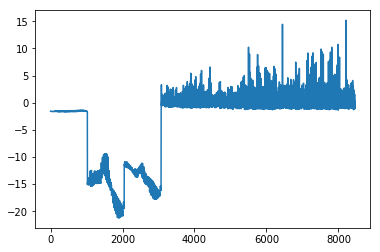

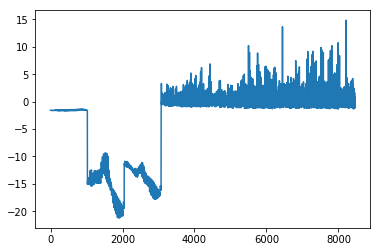

In [216]:
x = range(0, len(feats[num]))
plt.figure()
plt.plot(feats[num].ravel() - test_features.ravel())

plt.figure()
plt.plot(feats[num].ravel())

plt.figure()
plt.plot(test_features.ravel())

### 3.3 Multiple Detections & False Positives

In [187]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [188]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [189]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

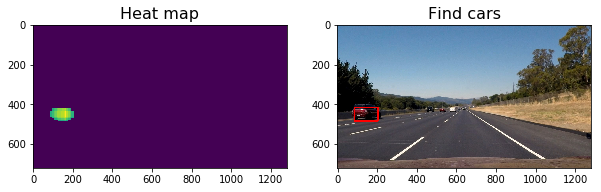

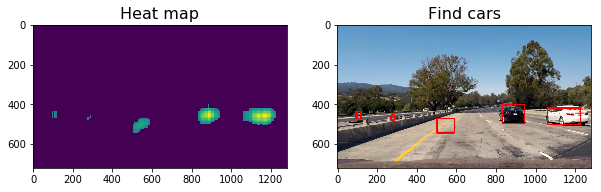

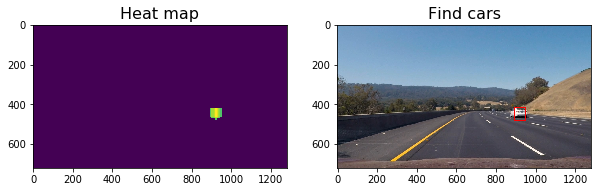

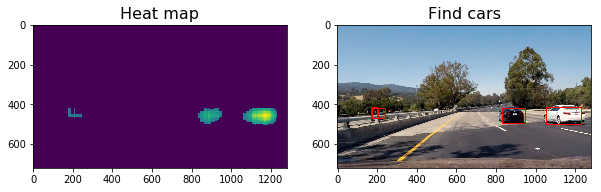

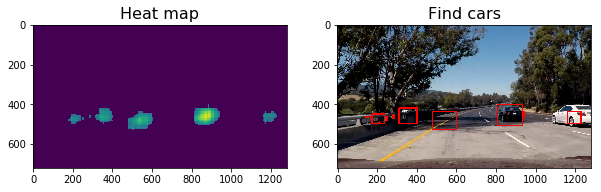

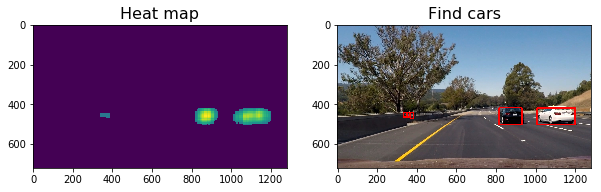

In [220]:
for idx1, (img, bbox) in enumerate(zip(imgs, list_bboxs)): 
      
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,bbox)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,15)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    #display origianl and transformation images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    ax1.imshow(heatmap)
    ax1.set_title('Heat map', fontsize=16)
    out_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    ax2.imshow(out_img)
    ax2.set_title('Find cars', fontsize=16)
    
    